**Check GPU information**

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Sat Dec 12 08:14:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Loading packages**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import sys
sys.path.append('/content/gdrive/My Drive/..')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import torchvision
from torchvision import transforms as transforms
import torch.nn.functional as F
import numpy as np
import os
from unet import UNet
from unet_2d import Unet_2D
# import augmentation
from augmentation import SegmentationAugmentation
from wrapper import UNetWrapper, UNet2DWrapper
from sklearn.metrics import adjusted_rand_score
from skimage import io
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import argparse
import random
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import math
import pandas as pd


In [5]:
for dirname, _, filenames in os.walk('/content/gdrive/My Drive/..'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

/content/gdrive/My Drive/IE_582/images_medseg.npy
/content/gdrive/My Drive/IE_582/images_radiopedia.npy
/content/gdrive/My Drive/IE_582/masks_medseg.npy
/content/gdrive/My Drive/IE_582/masks_radiopedia.npy
/content/gdrive/My Drive/IE_582/test_images_medseg.npy
/content/gdrive/My Drive/IE_582/covid-segmentation.zip
/content/gdrive/My Drive/IE_582/u-net-with-pytorch.ipynb
/content/gdrive/My Drive/IE_582/baseline-u-net-on-pytorch.ipynb
/content/gdrive/My Drive/IE_582/unet.py
/content/gdrive/My Drive/IE_582/unet_2d.py
/content/gdrive/My Drive/IE_582/augmentation.py
/content/gdrive/My Drive/IE_582/wrapper.py
/content/gdrive/My Drive/IE_582/__pycache__/unet_6.cpython-36.pyc
/content/gdrive/My Drive/IE_582/__pycache__/model.cpython-36.pyc
/content/gdrive/My Drive/IE_582/__pycache__/unet_2d.cpython-36.pyc
/content/gdrive/My Drive/IE_582/__pycache__/unet.cpython-36.pyc
/content/gdrive/My Drive/IE_582/__pycache__/augmentation.cpython-36.pyc
/content/gdrive/My Drive/IE_582/__pycache__/wrapper.cpy

**Loading Data**

In [6]:
# import the dataset
prefix = '/content/gdrive/My Drive/..'
images_radiopedia = np.load(os.path.join(prefix, 'images_radiopedia.npy')).astype(np.float32)
masks_radiopedia = np.load(os.path.join(prefix, 'masks_radiopedia.npy')).astype(np.float32)
images_medseg = np.load(os.path.join(prefix, 'images_medseg.npy')).astype(np.float32)
masks_medseg = np.load(os.path.join(prefix, 'masks_medseg.npy')).astype(np.float32)
# test_images_medseg = np.load(os.path.join(prefix, 'test_images_medseg.npy')).astype(np.float32)


In [7]:
# images = np.concatenate((images_radiopedia, images_medseg))
# masks = np.concatenate((masks_radiopedia, masks_medseg))

In [8]:
val_indexes, train_indexes = list(range(50)), list(range(50, 100))

train_images = np.concatenate((images_medseg[train_indexes], images_radiopedia[list(range(100, 829))]))
train_masks = np.concatenate((masks_medseg[train_indexes], masks_radiopedia[list(range(100, 829))]))
val_images = np.concatenate((images_medseg[val_indexes], images_radiopedia[val_indexes]))
val_masks = np.concatenate((masks_medseg[val_indexes],masks_radiopedia[val_indexes]))
test_images = images_radiopedia[list(range(50, 100))]
test_masks = masks_radiopedia[list(range(50, 100))]
train_images.shape, train_masks.shape

((779, 512, 512, 1), (779, 512, 512, 4))

In [9]:
# # train_ratio = 0.6
# # val_ratio = 0.2
# # test_ratio = 0.2
# random_state = 42
# train_images, val_test_images, train_masks, val_test_masks = train_test_split(
#     images, masks, test_size=0.8, random_state=42
# )
# val_images, test_images, val_masks, test_masks = train_test_split(
#     val_test_images, val_test_masks, test_size=0.5, random_state=42
# )
# train_images.shape, val_images.shape, test_images.shape

**Data Visualization**

In [11]:
def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))
    # label = ['(a) CT imgs', '(b) GGOS', '(c) Consolidation', '(d) Pleural effusion', '(e) backgrond']
    label = ['(a)', '(b)', '(c)', '(d)', '(e)']
    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i,:,:,0], cmap='Greys')
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        # text = label[i]
        if i == 0:
          ax_image.text(-0.25,0.5, s=label[0], size=15, ha="left", rotation="horizontal",
        transform=ax_image.transAxes)
        
        if mask_batch is not None:
            for j in range(num_classes):
                text = label[j+1]
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([])
                if i == 0:
                  ax[j + 1, i].text(-0.25,0.5-1.15*(j+1), s=text, size=15, ha="left", rotation="horizontal",
         transform=ax_image.transAxes) 

    plt.tight_layout()
    plt.show()

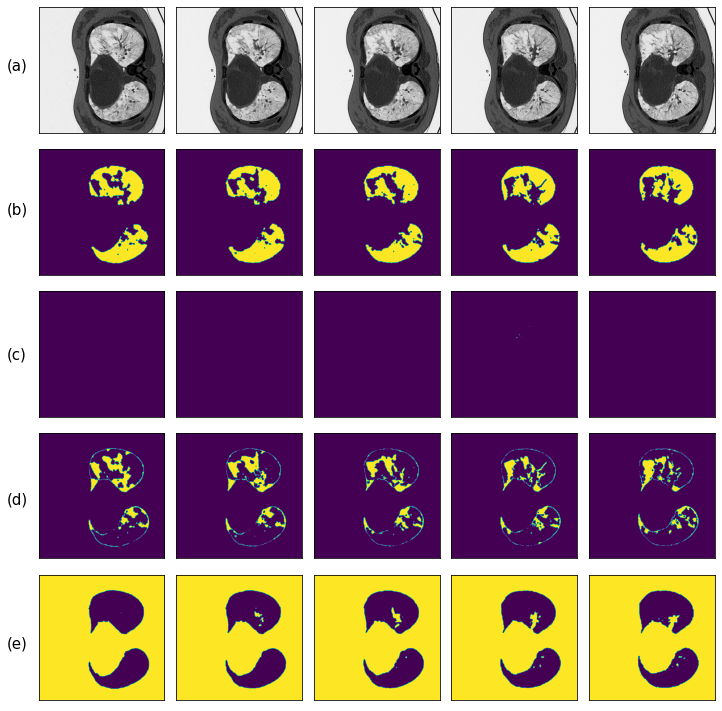

In [12]:
visualize(train_images[50:100], train_masks[50:100], num_samples=5)

**Exploratory data analysis**

In [13]:
def pre_process(images_arr, max_b=400, min_b=-1500):
  images_arr[images_arr > max_b] = max_b
  images_arr[images_arr < min_b] = min_b
  return (images_arr.mean(), images_arr.std()), images_arr

In [14]:
def plot_hists(images1, images2):
  fig = plt.figure(figsize=(10, 14))
  ax1 = fig.add_subplot(2,1,1)
  ax2 = fig.add_subplot(2,1,2)
  ax1.hist(images1.ravel(), bins=100, density=True, color='r', alpha=0.5, label='Radiopedia')
  ax1.hist(images2.ravel(), bins=100, density=True, alpha=0.5, color='b', label='MEDSEG')
  ax1.set_xlabel('HU')
  ax1.set_ylabel('Density')
  ax1.set_title('HU distribution before preprecessing', fontsize=16)
  ax1.legend()
  ax2.hist(pre_process(images1)[1].ravel(), bins=100, density=True, color='r', alpha=0.5, label='Radiopedia')
  ax2.hist(pre_process(images2)[1].ravel(), bins=100, density=True, color='b', alpha=0.5, label='MEDSEG')
  ax2.set_xlabel('HU')
  ax2.set_ylabel('Density')
  ax2.set_title('HU distribution after preprecessing', fontsize=16)
  ax2.legend()
  # plt.legend()
  plt.show()

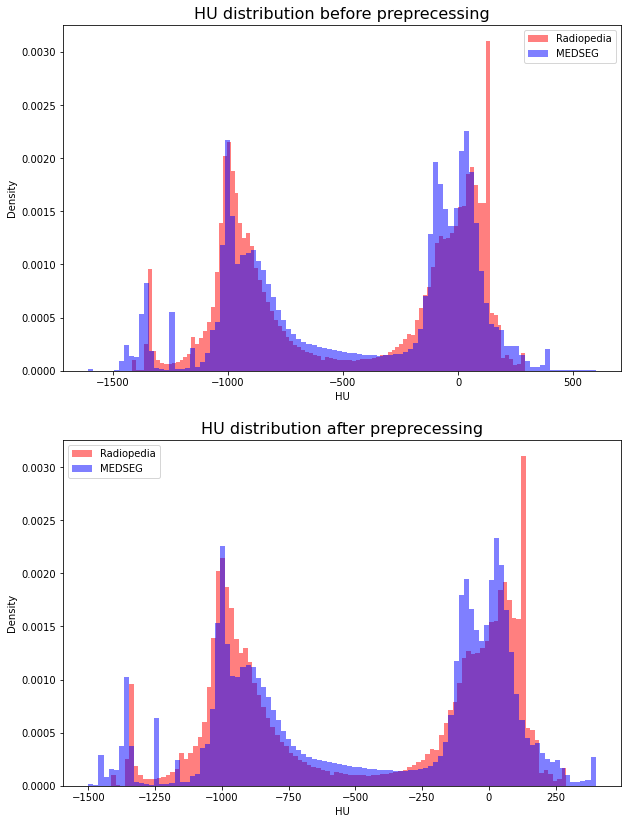

In [15]:
plot_hists(images_radiopedia, images_medseg)

**Define initialization function**

In [16]:
class CovidDataset(data.Dataset):
    def __init__(self, imgs, masks, transform=transforms.ToTensor()):
        self.imgs, self.masks = imgs, masks
        self.transform = transform
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, index):
        img1, mask1 = self.transform(self.imgs[index]).float(), self.transform(self.masks[index]).float()
        return (img1, mask1)



def intiData(imgs, masks, shuffle, batch_size=10, num_workers=4):
  imgs_p = pre_process(imgs)[1]
  dataset = CovidDataset(imgs_p, masks)
  dataloader = data.DataLoader(dataset, 
                               batch_size=batch_size, 
                               shuffle=shuffle, 
                               num_workers=num_workers
                               )
  return dataloader


In [17]:
def intiModel(model_type,device,use_cuda,
              flip=True,
              offset=0.03,
              scale=0.2,
              rotate=True,
              n_channels=1,
              n_classes=4
              ):
  if model_type == 'UNet':
    segmentation_model = UNetWrapper(
            in_channels=n_channels,
            n_classes=n_classes,
            depth=5,
            wf=4,
            padding=True,
            batch_norm=True,
            up_mode='upconv',
            )
  else:
    segmentation_model = UNet2DWrapper(n_channels=n_channels,n_classes=n_classes,mode='train')

  augmentation_dict = {}
  augmentation_dict['flip'] = flip
  augmentation_dict['offset'] = offset
  augmentation_dict['scale'] = scale
  augmentation_dict['rotate'] = rotate
  augmentation_model = SegmentationAugmentation(**augmentation_dict)

  if use_cuda:
    print("Using CUDA(); {} devices.".format(torch.cuda.device_count()))
    if torch.cuda.device_count() > 1:
      segmentation_model = nn.DataParallel(segmentation_model)
      augmentation_model = nn.DataParallel(augmentation_model)
    segmentation_model = segmentation_model.to(device)
    augmentation_model = augmentation_model.to(device)

  return segmentation_model, augmentation_model
  

In [18]:
def initOpt(type, lr, model):
  if type == 'Adam':
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
  else:
    optim = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=5e-4)
  return optim

**Define Loss function**

In [19]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=1, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss
          

In [20]:
def diceLoss(prediction, label, epsilon=1):
    label = label.view(-1)
    prediction = prediction.view(-1)
    intersection = (label * prediction).sum()
    return 1 - ((2 * intersection + epsilon) / (prediction.sum() + label.sum() + epsilon))

**Setting model parameters**

In [21]:
trainloader = intiData(train_images, train_masks, shuffle=True, batch_size=8)
valloader = intiData(val_images, val_masks, shuffle=False, batch_size=8)
testloader = intiData(test_images, test_masks, shuffle=False, batch_size=8)

In [22]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
focalLoss = FocalLoss(logits=True).to(device)

**Training Loop for UNet**

In [23]:
trian_batch = len(trainloader)
val_batch = len(valloader)
test_batch = len(testloader)
epochs = 20
mask_type = torch.float32
learn_rate = [1e-2, 1e-3, 1e-4]
opt_type = ['Adam', 'SGD']
ls_type = ['Dice', 'Focal']
data_lr = []
data_opt = []
data_set = []


for alpha in learn_rate:
 for optimizer_type in opt_type:
   for loss_type in ls_type:
      data_dict = {}
      data_lr.append(alpha)
      data_opt.append(optimizer_type)
      torch.cuda.empty_cache()
      model1, augmentation_model = intiModel(model_type='UNet',
                                            device=device,use_cuda=use_cuda)
      optim = initOpt(optimizer_type, alpha, model1)

      iteration = []
      train_loss1 = []
      train_loss2 = []
      val_loss1 = []
      val_loss2 = []
      model1.train()
    
      for epoch in range(1,epochs+1):
        iteration.append(epoch * len(trainloader))
        epoch_loss1 = 0
        epoch_loss2 = 0
        for img, mask in trainloader:
          img, mask = (img.to(device), mask.to(device, dtype=mask_type))
          img, mask = augmentation_model(img, mask)
          mask_pred = model1(img)
          diceloss = diceLoss(mask_pred, mask)
          focalloss = focalLoss(mask_pred, mask)
          epoch_loss1 += diceloss.item()
          epoch_loss2 += focalloss.item()
          optim.zero_grad()
          if loss_type == 'Dice':
            diceloss.backward()
          else:
            focalloss.backward()
          optim.step()

        if loss_type == 'Dice':
          train_loss1.append(epoch_loss1/trian_batch)
          print("Epoch: %d, Dice Loss: %f" %(epoch, epoch_loss1/trian_batch))
        else:
          train_loss2.append(epoch_loss2/trian_batch)
          print("Epoch: %d, Focal Loss: %f" %(epoch, epoch_loss2/trian_batch))

        model1.eval()
        total_val1 = 0.0
        total_val2 = 0.0
        with torch.no_grad():
          for img, mask in valloader:
            img, mask = (img.to(device), mask.to(device, dtype=mask_type))
            img, mask = augmentation_model(img, mask)
            mask_pred = model1(img)
            val_diceloss = diceLoss(mask_pred, mask)
            val_focalloss = focalLoss(mask_pred, mask)
            total_val1 += val_diceloss.item()
            total_val2 += val_focalloss.item()

        # val_loss = total_val.item() / val_batch
        if loss_type == 'Dice':
          val_loss1.append(total_val1/val_batch)
          print("Epoch: %d, Val Loss: %f" %(epoch, total_val1/val_batch))
        else:
          val_loss2.append(total_val2/val_batch)   
          print("Epoch: %d, Val Loss: %f" %(epoch, total_val2/val_batch))
        
        model1.eval()
        total_test1 = 0.0
        total_test2 = 0.0
        with torch.no_grad():
          for img, mask in testloader:
            img, mask = (img.to(device), mask.to(device, dtype=mask_type))
            img, mask = augmentation_model(img, mask)
            mask_pred = model1(img)
            test_diceloss = diceLoss(mask_pred, mask)
            test_focalloss = focalLoss(mask_pred, mask)
            total_test1 += test_diceloss.item()
            total_test2 += test_focalloss.item()
        if loss_type == 'Dice': 
          test_loss1 = total_test1/test_batch
        else:
          test_loss2 = total_test2/test_batch
      if loss_type == 'Dice':
        data_dict['iteration'] = iteration
        data_dict['train_loss1'] = train_loss1
        data_dict['val_loss1'] = val_loss1
        data_dict['test_loss1'] = test_loss1
      else:
        data_dict['iteration'] = iteration
        data_dict['train_loss2'] = train_loss2  
        data_dict['val_loss2'] = val_loss2
        data_dict['test_loss2'] = test_loss2
        
      data_set.append(data_dict)


Using CUDA(); 1 devices.


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch: 1, Dice Loss: 0.214368
Epoch: 1, Val Loss: 0.240446
Epoch: 2, Dice Loss: 0.171109
Epoch: 2, Val Loss: 0.209570
Epoch: 3, Dice Loss: 0.173817
Epoch: 3, Val Loss: 0.257705
Epoch: 4, Dice Loss: 0.167573
Epoch: 4, Val Loss: 0.245379
Epoch: 5, Dice Loss: 0.171428
Epoch: 5, Val Loss: 0.247981
Epoch: 6, Dice Loss: 0.168028
Epoch: 6, Val Loss: 0.244528
Epoch: 7, Dice Loss: 0.170626
Epoch: 7, Val Loss: 0.242581
Epoch: 8, Dice Loss: 0.168928
Epoch: 8, Val Loss: 0.246145
Epoch: 9, Dice Loss: 0.171908
Epoch: 9, Val Loss: 0.254439
Epoch: 10, Dice Loss: 0.169911
Epoch: 10, Val Loss: 0.236401
Epoch: 11, Dice Loss: 0.168973
Epoch: 11, Val Loss: 0.235117
Epoch: 12, Dice Loss: 0.175509
Epoch: 12, Val Loss: 0.252137
Epoch: 13, Dice Loss: 0.170573
Epoch: 13, Val Loss: 0.237718
Epoch: 14, Dice Loss: 0.169584
Epoch: 14, Val Loss: 0.230022
Epoch: 15, Dice Loss: 0.169017
Epoch: 15, Val Loss: 0.258750
Epoch: 16, Dice Loss: 0.171017
Epoch: 16, Val Loss: 0.271080
Epoch: 17, Dice Loss: 0.173221
Epoch: 17, 

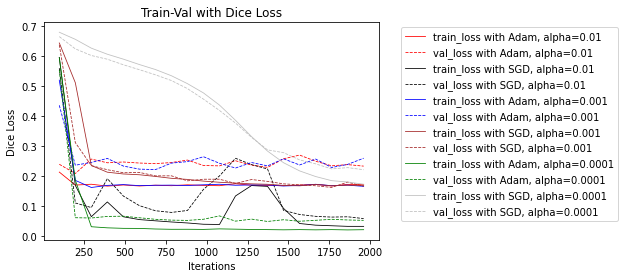

In [26]:
for i, color in enumerate(['red', 'black', 'blue', 'brown', 'green', 'silver']):
  plt.plot(data_set[2*i]['iteration'], data_set[2*i]['train_loss1'], 
           label = "train_loss with {}, alpha={}".format(data_opt[2*i], data_lr[2*i]),
           linewidth=0.8, color=color)
  
  plt.plot(data_set[2*i]['iteration'], data_set[2*i]['val_loss1'], 
           label = "val_loss with {}, alpha={}".format(data_opt[2*i], data_lr[2*i]),
           linestyle='--', linewidth=0.8, color=color)
plt.xlabel("Iterations")
plt.ylabel("Dice Loss")
plt.title("Train-Val with Dice Loss")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

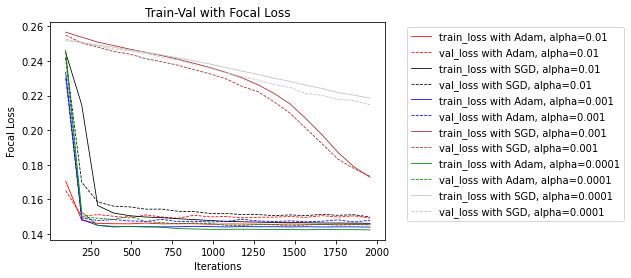

In [27]:
for i, color in enumerate(['red', 'black', 'blue', 'brown', 'green', 'silver']):
  plt.plot(data_set[2*i+1]['iteration'], data_set[2*i+1]['train_loss2'], 
            label = "train_loss with {}, alpha={}".format(data_opt[2*i+1], data_lr[2*i+1]),
            linewidth=0.8, color=color)
  plt.plot(data_set[2*i+1]['iteration'], data_set[2*i+1]['val_loss2'], 
            label = "val_loss with {}, alpha={}".format(data_opt[2*i+1], data_lr[2*i+1]),
            linestyle='--', linewidth=0.8, color=color)
plt.xlabel("Iterations")
plt.ylabel("Focal Loss")
plt.title("Train-Val with Focal Loss")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [32]:
Dice_accuracy = []
Focal_accuracy = []

for i in range(6):
  Dice_accuracy.append(1- data_set[i*2]['test_loss1'])
  Focal_accuracy.append(1- data_set[i*2+1]['test_loss2'])
ac_data = pd.DataFrame()
ac_data['Dice accuracy'] = Dice_accuracy
ac_data['Focal accuracy'] = Focal_accuracy
ac_data['Learning rate'] = data_lr[0:12:2]
ac_data['Optimizer'] = data_opt[0:12:2]

ac_data

,Dice accuracy,Focal accuracy,Learning rate,Optimizer
0,0.927333,0.853719,0.0100,Adam
1,0.951266,0.853675,0.0100,SGD
2,0.917574,0.854889,0.0010,Adam
3,0.782097,0.833212,0.0010,SGD
4,0.951600,0.857212,0.0001,Adam
5,0.891029,0.788257,0.0001,SGD


Training Loop for UNet++

In [51]:
trian_batch = len(trainloader)
val_batch = len(valloader)
test_batch = len(testloader)
epochs = 20
mask_type = torch.float32
learn_rate = [1e-2, 1e-3, 1e-4]
opt_type = ['Adam', 'SGD']
ls_type = ['Dice', 'Focal']
data_lr = []
data_opt = []
data_set1 = []


for alpha in learn_rate:
 for optimizer_type in opt_type:
   for loss_type in ls_type:

      data_dict = {}
      data_lr.append(alpha)
      data_opt.append(optimizer_type)
      torch.cuda.empty_cache()
      model1, augmentation_model = intiModel(model_type='UNet_2D',
                                            device=device,use_cuda=use_cuda)
      optim = initOpt(optimizer_type, alpha, model1)

      iteration = []
      train_loss1 = []
      train_loss2 = []
      val_loss1 = []
      val_loss2 = []
      model1.train()
      model1.mode='train'
      for epoch in range(1,epochs+1):
        iteration.append(epoch * len(trainloader))
        epoch_loss1 = 0
        epoch_loss2 = 0
        for img, mask in trainloader:
          img, mask = (img.to(device), mask.to(device, dtype=mask_type))
          img, mask = augmentation_model(img, mask)
          mask_pred = model1(img)
          diceloss, focalloss = 0, 0  
          for output in mask_pred:
            diceloss += diceLoss(output, mask)
            focalloss += focalLoss(output, mask)
          diceloss /= len(mask_pred)
          focalloss /= len(mask_pred)
          epoch_loss1 += diceloss.item()
          epoch_loss2 += focalloss.item()
          optim.zero_grad()
          if loss_type == 'Dice':
            diceloss.backward()
          else:
            focalloss.backward()
          optim.step()
        if loss_type == 'Dice':
          train_loss1.append(epoch_loss1/trian_batch)
          print("Epoch: %d, Dice Loss: %f" %(epoch, epoch_loss1/trian_batch))
        else:
          train_loss2.append(epoch_loss2/trian_batch)
          print("Epoch: %d, Focal Loss: %f" %(epoch, epoch_loss2/trian_batch))
        

        model1.eval()
        model1.mode='test'
        total_val1 = 0.0
        total_val2 = 0.0
        with torch.no_grad():
          for img, mask in valloader:
            img, mask = (img.to(device), mask.to(device, dtype=mask_type))
            img, mask = augmentation_model(img, mask)
            mask_pred = model1(img)
            val_diceloss, val_focalloss = 0.0, 0.0
            for output in mask_pred:          
              val_diceloss += diceLoss(output, mask)
              val_focalloss += focalLoss(output, mask)
            val_diceloss /= len(mask_pred)
            val_focalloss /= len(mask_pred)
            total_val1 += val_diceloss.item()
            total_val2 += val_focalloss.item()

        # val_loss = total_val.item() / val_batch
        if loss_type == 'Dice':
          val_loss1.append(total_val1/val_batch)
          print("Epoch: %d, Val Loss: %f" %(epoch, total_val1/val_batch))
        else:
          val_loss2.append(total_val2/val_batch)
          print("Epoch: %d, Val Loss: %f" %(epoch, total_val2/val_batch))
        
        
        
        model1.eval()
        model1.mode='test'
        total_test1 = 0.0
        total_test2 = 0.0
        with torch.no_grad():
          for img, mask in testloader:
            img, mask = (img.to(device), mask.to(device, dtype=mask_type))
            img, mask = augmentation_model(img, mask)
            mask_pred = model1(img)
            test_diceloss, test_focalloss = 0.0, 0.0
            for output in mask_pred:
              test_diceloss += diceLoss(output, mask)
              test_focalloss += focalLoss(output, mask)
            test_diceloss /= len(mask_pred)
            test_focalloss /= len(mask_pred)
            total_test1 += test_diceloss.item()
            total_test2 += test_focalloss.item()

        if loss_type == 'Dice': 
          test_loss1 = total_test1/test_batch
        else:
          test_loss2 = total_test2/test_batch

      if loss_type == 'Dice':
        data_dict['iteration'] = iteration
        data_dict['train_loss1'] = train_loss1
        data_dict['val_loss1'] = val_loss1
        data_dict['test_loss1'] = test_loss1
      else:
        data_dict['iteration'] = iteration
        data_dict['train_loss2'] = train_loss2  
        data_dict['val_loss2'] = val_loss2
        data_dict['test_loss2'] = test_loss2
        
      data_set1.append(data_dict)


Using CUDA(); 1 devices.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch: 1, Dice Loss: 0.211483
Epoch: 1, Val Loss: 0.111519
Epoch: 2, Dice Loss: 0.168680
Epoch: 2, Val Loss: 0.251215
Epoch: 3, Dice Loss: 0.171648
Epoch: 3, Val Loss: 0.247854
Epoch: 4, Dice Loss: 0.173406
Epoch: 4, Val Loss: 0.258921
Epoch: 5, Dice Loss: 0.172736
Epoch: 5, Val Loss: 0.253866
Epoch: 6, Dice Loss: 0.171880
Epoch: 6, Val Loss: 0.230616
Epoch: 7, Dice Loss: 0.168785
Epoch: 7, Val Loss: 0.234518
Epoch: 8, Dice Loss: 0.169744
Epoch: 8, Val Loss: 0.276090
Epoch: 9, Dice Loss: 0.169371
Epoch: 9, Val Loss: 0.238181
Epoch: 10, Dice Loss: 0.173084
Epoch: 10, Val Loss: 0.240289
Epoch: 11, Dice Loss: 0.171441
Epoch: 11, Val Loss: 0.254344
Epoch: 12, Dice Loss: 0.171421
Epoch: 12, Val Loss: 0.230866
Epoch: 13, Dice Loss: 0.168502
Epoch: 13, Val Loss: 0.242165
Epoch: 14, Dice Loss: 0.168242
Epoch: 14, Val Loss: 0.233465
Epoch: 15, Dice Loss: 0.170510
Epoch: 15, Val Loss: 0.234634
Epoch: 16, Dice Loss: 0.167842
Epoch: 16, Val Loss: 0.254183
Epoch: 17, Dice Loss: 0.165988
Epoch: 17, 

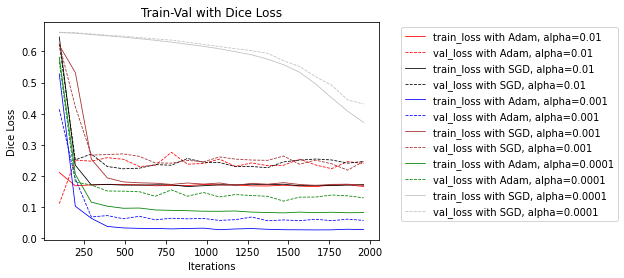

In [52]:
for i, color in enumerate(['red', 'black', 'blue', 'brown', 'green', 'silver']):
  plt.plot(data_set1[2*i]['iteration'], data_set1[2*i]['train_loss1'], 
           label = "train_loss with {}, alpha={}".format(data_opt[2*i], data_lr[2*i]),
           linewidth=0.8, color=color)
  
  plt.plot(data_set1[2*i]['iteration'], data_set1[2*i]['val_loss1'], 
           label = "val_loss with {}, alpha={}".format(data_opt[2*i], data_lr[2*i]),
           linestyle='--', linewidth=0.8, color=color)
plt.xlabel("Iterations")
plt.ylabel("Dice Loss")
plt.title("Train-Val with Dice Loss")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

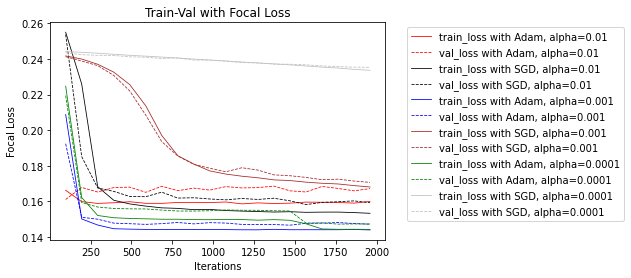

In [54]:
for i, color in enumerate(['red', 'black', 'blue', 'brown', 'green', 'silver']):
  plt.plot(data_set1[2*i+1]['iteration'], data_set1[2*i+1]['train_loss2'], 
            label = "train_loss with {}, alpha={}".format(data_opt[2*i+1], data_lr[2*i+1]),
            linewidth=0.8, color=color)
  plt.plot(data_set1[2*i+1]['iteration'], data_set1[2*i+1]['val_loss2'], 
            label = "val_loss with {}, alpha={}".format(data_opt[2*i+1], data_lr[2*i+1]),
            linestyle='--', linewidth=0.8, color=color)
plt.xlabel("Iterations")
plt.ylabel("Focal Loss")
plt.title("Train-Val with Focal Loss")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()


In [60]:
Dice_accuracy1 = []
Focal_accuracy1 = []

for i in range(6):
  Dice_accuracy1.append(1- data_set1[i*2]['test_loss1'])
  Focal_accuracy1.append(1- data_set1[i*2+1]['test_loss2'])
ac_data1 = pd.DataFrame()
ac_data1['Dice accuracy'] = Dice_accuracy1
ac_data1['Focal accuracy'] = Focal_accuracy1
ac_data1['Learning rate'] = data_lr[0:12:2]
ac_data1['Optimizer'] = data_opt[0:12:2]

ac_data1

,Dice accuracy,Focal accuracy,Learning rate,Optimizer
0,0.928459,0.851180,0.0100,Adam
1,0.913840,0.853252,0.0100,SGD
2,0.951132,0.854090,0.0010,Adam
3,0.915894,0.832773,0.0010,SGD
4,0.945569,0.854025,0.0001,Adam
5,0.698651,0.768633,0.0001,SGD
